# Wilcoxon signed rank test
After having verified in [the preliminary analysis](./data_analysis_preliminary.ipynb) that the data is **not** normally distributed, we applied the [Wilcoxon signed rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) to obtain the statistical significance of the within-subjects difference of RMSSD

In [22]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import wilcoxon

# load participant-level means
mean_table = pd.read_csv("rmssd_per_participant.csv")

# select paired participant-level means (drop participants missing either label)
paired = mean_table[["AI Generated", "Human Generated"]].dropna()
ai_vals = paired["AI Generated"].values
human_vals = paired["Human Generated"].values

stat, p = wilcoxon(ai_vals, human_vals, alternative="two-sided", zero_method="wilcox")
n = len(ai_vals)

# approximate effect size r
expected_W = n * (n + 1) / 4.0
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24.0)
z = (stat - expected_W) / std_W if std_W > 0 else np.nan
r = z / np.sqrt(n) if n > 0 else np.nan

print(f"n = {n}")
print(f"Wilcoxon W = {stat:.3f}, p = {p:.4f}")
print(f"approx. z = {z:.3f}, effect size r = {r:.3f}")
print(f"median AI = {np.median(ai_vals):.3f}, median Human = {np.median(human_vals):.3f}, median(AI-Human) = {np.median(ai_vals-human_vals):.3f}")

n = 22
Wilcoxon W = 102.000, p = 0.4434
approx. z = -0.795, effect size r = -0.170
median AI = 32.323, median Human = 32.109, median(AI-Human) = -0.463


## Confidence intervals and plots

Hodges-Lehmann (median difference) = -0.463 ms
Bootstrap 95% CI (percentile) for median difference = [-3.950, 1.793] ms


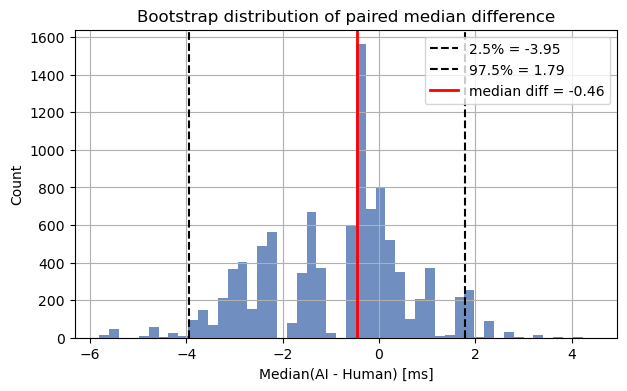

'AI-generated' median = 32.323 ms, bootstrap 95% CI = [15.473, 60.439]
'Human-generated' median = 32.109 ms, bootstrap 95% CI = [18.141, 52.567]


In [23]:
# -----------------------------
# Bootstrap 95% CI for median difference (paired)
# -----------------------------

diffs = ai_vals - human_vals
hl = np.median(diffs)  # Hodges-Lehmann (median of paired differences)

def bootstrap_paired_median_diff(a, b, n_boot=10000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(a)
    # resample participant indices with replacement
    idxs = rng.integers(0, n, size=(n_boot, n))
    boot_meds = np.array([np.median(a[idx] - b[idx]) for idx in idxs])
    return boot_meds

boot_meds = bootstrap_paired_median_diff(ai_vals, human_vals, n_boot=10000, seed=42)
ci_lower, ci_upper = np.percentile(boot_meds, [2.5, 97.5])

print(f"Hodges-Lehmann (median difference) = {hl:.3f} ms")
print(f"Bootstrap 95% CI (percentile) for median difference = [{ci_lower:.3f}, {ci_upper:.3f}] ms")

# Plot bootstrap distribution
plt.figure(figsize=(7,4))
plt.hist(boot_meds, bins=50, color="#4c72b0", alpha=0.8)
plt.axvline(ci_lower, color="k", linestyle="--", label=f"2.5% = {ci_lower:.2f}")
plt.axvline(ci_upper, color="k", linestyle="--", label=f"97.5% = {ci_upper:.2f}")
plt.axvline(hl, color="red", linewidth=2, label=f"median diff = {hl:.2f}")
plt.xlabel("Median(AI - Human) [ms]")
plt.ylabel("Count")
plt.title("Bootstrap distribution of paired median difference")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Optional: bootstrap CIs for marginal medians (AI, Human)
# -----------------------------
def bootstrap_paired_marginal_medians(a, b, n_boot=10000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(a)
    idxs = rng.integers(0, n, size=(n_boot, n))
    boot_med_a = np.array([np.median(a[idx]) for idx in idxs])
    boot_med_b = np.array([np.median(b[idx]) for idx in idxs])
    return boot_med_a, boot_med_b

boot_med_a, boot_med_b = bootstrap_paired_marginal_medians(ai_vals, human_vals, n_boot=10000, seed=42)
ai_ci = np.percentile(boot_med_a, [2.5, 97.5])
human_ci = np.percentile(boot_med_b, [2.5, 97.5])

print(f"'AI-generated' median = {np.median(ai_vals):.3f} ms, bootstrap 95% CI = [{ai_ci[0]:.3f}, {ai_ci[1]:.3f}]")
print(f"'Human-generated' median = {np.median(human_vals):.3f} ms, bootstrap 95% CI = [{human_ci[0]:.3f}, {human_ci[1]:.3f}]")